# Fitting oscillations with noise

This excersize allow you to fit oscillatory datasets and compare different methods to obtain the most precise values. 
We will in particular:
1. Find situations where "standard fitting works and where it doesn't.
2. Apply methods of Fourier analysis.
3. Use Peak fitting algorithms to define parameters


The exercise is made to play around with a simple, self generated data and combine calculations with direct simulations. This is not curriculum, but can turn in valuable for your future careers. 

### References:
- Lecture on Time series

### Authors: 
- Mathias L. Heltberg (Niels Bohr Institute)

### Date:    
- 07-01-2024 (latest update)

***

As always we will include a collection of libraries (Standard)

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
from numpy.linalg import matrix_power                  # This is to raise matrices to powers
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
from scipy.fft import fft,fftfreq

Naturally we will here need a random generator:

In [2]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

Next we will generate some data:

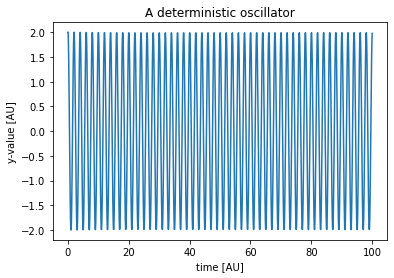

In [3]:
t = 0; dt = 0.0001; omega = np.pi
x = 2; y = 1; tmax = 100;

ts = 0.1; click = 0;
dS1 = np.zeros((int(tmax/ts)+1,3));

while t < tmax:
    t += dt
    dx = y;
    dy = -omega**2*x + 0.1*y*(1-x**2);
    x += dt*dx
    y += dt*dy
    if (t>ts*click):
        dS1[click,0] = t;
        dS1[click,1] = x;
        dS1[click,2] = y;
        click+=1
plt.plot(dS1[:,0],dS1[:,1])
plt.xlabel('time [AU]'); plt.ylabel('y-value [AU]'); plt.title('A deterministic oscillator')
plt.show()

Now we insert experimental noise levels - i.e. randomness in the measurements:

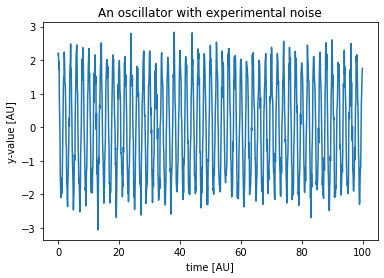

In [4]:
t = 0; dt = 0.0001; omega = np.pi
x = 2; y = 1; tmax = 100;

ts = 0.1; click = 0;
dS2 = np.zeros((int(tmax/ts)+1,3));
sigma_exp = 0.33;
while t < tmax:
    t += dt
    dx = y;
    dy = -omega**2*x + 0.1*y*(1-x**2);
    x += dt*dx
    y += dt*dy
    if (t>ts*click):
        dS2[click,0] = t;
        dS2[click,1] = x + np.random.normal()*sigma_exp;
        dS2[click,2] = y + np.random.normal()*sigma_exp;
        click+=1
plt.plot(dS2[:,0],dS2[:,1])
plt.xlabel('time [AU]'); plt.ylabel('y-value [AU]'); plt.title('An oscillator with experimental noise')
plt.show()


Now we insert stochasticity in the traces and experimental noise levels:

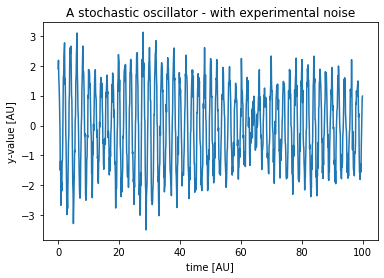

In [5]:
t = 0; dt = 0.0001; omega = np.pi
x = 2; y = 1; tmax = 100;

ts = 0.1; click = 0;
dS3 = np.zeros((int(tmax/ts)+1,3));
sigma_exp = 0.33;
sigma_trace = 1;
while t < tmax:
    t += dt
    dx = y;
    dy = -omega**2*x + 0.1*y*(1-x**2);
    x += dt*dx 
    y += dt*dy + np.random.normal()*np.sqrt(dt)*sigma_trace
    if (t>ts*click):
        dS3[click,0] = t;
        dS3[click,1] = x + np.random.normal()*sigma_exp;
        dS3[click,2] = y + np.random.normal()*sigma_exp;
        click+=1
plt.plot(dS3[:,0],dS3[:,1])
plt.xlabel('time [AU]'); plt.ylabel('y-value [AU]'); plt.title('A stochastic oscillator - with experimental noise')
plt.show()

And finally lets assume that we on top of all this has a stochastic drift in the background:

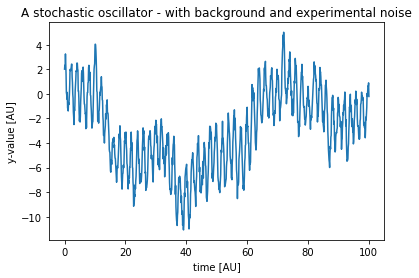

In [6]:
t = 0; dt = 0.0001; omega = np.pi
x = 2; y = 1; tmax = 100;

ts = 0.1; click = 0; c = 0;
dS4 = np.zeros((int(tmax/ts)+1,3));
sigma_exp = 0.33;
sigma_c = 1;
sigma_trace = 1;
while t < tmax:
    t += dt
    dx = y;
    dy = -omega**2*x + 0.1*y*(1-x**2);
    c += np.random.normal()*np.sqrt(dt)*sigma_c;
    x += dt*dx 
    y += dt*dy + np.random.normal()*np.sqrt(dt)*sigma_trace
    if (t>ts*click):
        dS4[click,0] = t;
        dS4[click,1] = x + np.random.normal()*sigma_exp + c;
        dS4[click,2] = y + np.random.normal()*sigma_exp + c;
        click+=1
plt.plot(dS4[:,0],dS4[:,1])
plt.xlabel('time [AU]'); plt.ylabel('y-value [AU]'); plt.title('A stochastic oscillator - with background and experimental noise')
plt.show()


## We now have 4 datasets, dS1,dS2,dS3 and dS4. We want to compare methods that determine the frequency and the amplitude of these traces.

To apply the Fourier analysis, a template is here made to estimate the amplitudes and frequencies of $x=sin(t)+0.1\cdot sin(10t)$

In [ ]:
TS = 0.1;
t = np.linspace(1,1000,1000)*TS
x = np.sin(t)+0.1*np.sin(10*t)
N = len(x); 
yf = fft(x); xf = fftfreq(N, TS)[:N//2]
yn = 2.0/N * np.abs(yf[0:N//2]);
xn = xf[1:]
zn = yn[1:]

plt.plot(xn*(2*np.pi),zn)

Determining the frequency and amplitude is quite dependent on estimating the position of the peaks. A VERY SIMPLE (maybe too simple) algorithm could be the following:

In [ ]:
X = dS2[:,1];
peaks = [];
n_sig = 5;
for i in range (n_sig,len(X)-n_sig):
    acc = 1;
    for itmp in range (1,n_sig+1):
        if (X[i]>X[i-itmp] and X[i]>X[i+itmp]):
            continue
        else:
            acc = 0
    if acc == 1:
        peaks.append(i)
peaks = np.array(peaks)
plt.plot(dS2[:,0],dS2[:,1])
plt.plot(dS2[peaks,0],dS2[peaks,1],'o')


Fitting a simple dataset is naturally done in the following way:

In [ ]:
##### Note this is a simple fitting algorithm - should be applied for question 1 ##########
t = np.linspace(1,100,10000)
y_sig = 0.3
y = 2*np.sin(np.sqrt(2)*t)+np.random.normal(0,y_sig,10000)
plt.plot(t,y)

def Osci(t,A,omega):
    return A*np.sin(omega*t)
def min_Osci(A,omega):
    Chi2 = ((y-Osci(t,A,omega))/y_sig)**2
    return np.sum(Chi2)
m_nll2 = Minuit(min_Osci,A=1,omega=np.sqrt(2.1)); m_nll2.limits['A'] = (0,10000); m_nll2.limits['omega'] = (0,100); 
m_nll2.errordef = 1.0;
m_nll2.migrad()
A_fit = m_nll2.values[0]
omega_fit = m_nll2.values[1]

plt.plot(t,Osci(t,A_fit,omega_fit))

In [ ]:
##### Note this is for the Advanced question ##########

t = 0; dt = 0.0001; omega = np.pi
x1 = 2; y1 = 1; x2 = 2; y2 = 1; x3 = 2; y3 = 1; x4 = 2; y4 = 1; 
sigma_trace = 1
sigma_exp = 0.1;
tmax = 100;
dS8 = np.zeros((int(tmax/ts)+1,9));
ts = 0.1; click = 0;
def dfx (x,y):    
    dx = y;
    dy = -omega**2*x + 0.1*y*(1-x**2);
    x += dt*dx 
    y += dt*dy + np.random.normal()*np.sqrt(dt)*sigma_trace
    return (x,y)
    
while t < tmax:
    t += dt
    x1,y1 = dfx(x1,y1)
    x2,y2 = dfx(x2,y2)
    x3,y3 = dfx(x3,y3)
    x4,y4 = dfx(x4,y4)
    if (t>ts*click):
        dS8[click,0] = t;
        dS8[click,1] = x1 + np.random.normal()*sigma_exp;
        dS8[click,2] = y1 + np.random.normal()*sigma_exp;
        dS8[click,3] = x2 + np.random.normal()*sigma_exp;
        dS8[click,4] = y2 + np.random.normal()*sigma_exp;
        dS8[click,5] = x3 + np.random.normal()*sigma_exp;
        dS8[click,6] = y3 + np.random.normal()*sigma_exp;
        dS8[click,7] = x4 + np.random.normal()*sigma_exp;
        dS8[click,8] = y4 + np.random.normal()*sigma_exp;
        click+=1
        
        
t = dS8[:,0]
idx = np.random.permutation(8)
D_mat = dS8[:,1:]; D_mat = D_mat[:,idx]

plt.plot(t,D_mat[:,0])
plt.plot(t,D_mat[:,1])

plt.xlabel('time [AU]'); plt.ylabel('y-value [AU]'); plt.title('')
plt.show()

## Questions:

This exercise is made to test your ability to extract particular features in the some quite stochastic data:

1) Start by applying the standard minuit fit. How many data sets can you fit and which values do you obtain? What about the uncertainty? For which data set does this method break down? Think about why! (note: for the completely deterministic case, you can fit without uncertainties - but do not put these to zero!)

2) Now try to apply the Fourier analysis as written in the template. Can you estimate the parameters in all four data sets? (hint: You might have to subtact background by a polynomial fitting on the 4th dataset)

3) Try to apply the peak finding algorithm (or write a better yourself!). Can you apply the methods similar to the fitting you applied related to the pendulum experiment. How precise can you estimate the parameters of the data sets?

### Advanced question:

4) In the matrix, D_mat, you have 8 time series of which they are generated in pairs. That means that each time series does have a "natural partner". Can you determine which series are partners?


# Learning points

This is simple introduction to the analysis of time series with the potentially most fundamental problem: The oscillator.

It is important that we can apply the fitting techniques learnt so far, but sometimes these might break down. Here the good scientist can break the problem down and focus on the main element - here extracting the frequency and amplitude from some very stochastic traces.

From this exercise, you should have learned:

1) How to fit oscillatory data - this should be accomplihsed for the first two datasets. 

2) How to apply the Fourier analysis and extract the values of an oscillatory time series

3) Find and indentify the peaks of a time series and apply the methods previously used